In [1]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np

# Load a NEON AOP image

In [20]:
neon_image= '/data/srer/NEON_D14_SRER_DP1_20190901_171112_reflectance.h5'

neon = ht.HyTools()
neon.read_file(neon_image,'neon')

# Load an ENVI image

In [22]:
envi_image= '/data/yose/f130612t01p00r10_rfl_v1a_img_clip'

anc_data = {'path_length': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 0],
 'sensor_az': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 1],
 'sensor_zn': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 2],
 'solar_az': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 3],
 'solar_zn': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 4],
 'phase': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 5],
 'slope': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 6],
 'aspect': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 7],
 'cosine_i': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 8],
 'utc_time': ['/data/yose/f130612t01p00r10rdn_e_obs_ort_clip', 9]}

envi = ht.HyTools()
envi.read_file(envi_image,'envi',anc_path=anc_data)

In [26]:
neon.map_info


['UTM',
 '  1.000',
 '  1.000',
 '  513686.000',
 '  3532567.000',
 '  1.0000000000e+000',
 '  1.0000000000e+000',
 '  12',
 '  North',
 '  WGS-84',
 '  units=Meters',
 ' 0']

## Examples of get methods

In [27]:
line = envi.get_line(100, corrections = [])
band = envi.get_band(10)
wave = envi.get_wave(660)
pixel = envi.get_pixels([500],[500])

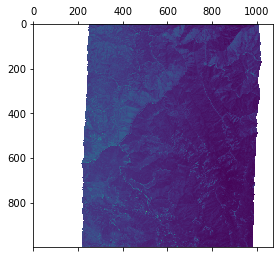

In [28]:
band = np.copy(band)
band[~envi.mask['no_data']] = np.nan
plt.matshow(band)

### Load precomputed correction coefficients

In [29]:
topo_coeffs = '/data/yose/f130612t01p00r10_rfl_v1a_img_topo_coeffs_full.json'
envi.load_coeffs(topo_coeffs,'topo')

brdf_coeffs = '/data/yose/f130612t01p00r10_rfl_v1a_img_brdf_coeffs_full.json'
envi.load_coeffs(brdf_coeffs,'brdf')

In [30]:
print(envi.brdf)

{'type': 'flex', 'grouped': True, 'geometric': 'li_sparse_r', 'volume': 'ross_thick', 'b/r': 1, 'h/b': 2, 'sample_perc': 0.5, 'interp_kind': 'linear', 'ndvi_min': 0.2, 'ndvi_max': 1.0, 'solar_zn_norm': True, 'neon_buffer': False, 'sensor_zn_min': 0.03490658503988659, 'bin_type': 'dynamic', 'num_bins': 18, 'ndvi_bin_min': 0.05, 'ndvi_bin_max': 1.0, 'ndvi_perc_min': 10, 'ndvi_perc_max': 95, 'mean_solar_zenith': 0.4667205512523651, 'bins': {'1': [0.05, 0.1492788940668106], '2': [0.1492788940668106, 0.1968869236637564], '3': [0.1968869236637564, 0.23008230328559875], '4': [0.23008230328559875, 0.2598400101240944], '5': [0.2598400101240944, 0.29599809646606445], '6': [0.29599809646606445, 0.33405953645706177], '7': [0.33405953645706177, 0.3717491537683151], '8': [0.3717491537683151, 0.40972086787223816], '9': [0.40972086787223816, 0.4483635127544403], '10': [0.4483635127544403, 0.48746879255070397], '11': [0.48746879255070397, 0.5263502597808838], '12': [0.5263502597808838, 0.56458872556686

#### Function for reading from and displaying a RGB image preview

In [ ]:
def show_rgb(hy_obj,r=660,g=550,b=440, correct= []):

    rgb=  np.stack([hy_obj.get_wave(r,corrections= correct),
                    hy_obj.get_wave(g,corrections= correct),
                    hy_obj.get_wave(b,corrections= correct)])
    rgb = np.moveaxis(rgb,0,-1).astype(float)
    rgb[rgb ==hy_obj.no_data] = np.nan

    bottom = np.nanpercentile(rgb,5,axis = (0,1))
    top = np.nanpercentile(rgb,95,axis = (0,1))
    rgb = np.clip(rgb,bottom,top)

    rgb = (rgb-np.nanmin(rgb,axis=(0,1)))/(np.nanmax(rgb,axis= (0,1))-np.nanmin(rgb,axis= (0,1)))

    height = int(hy_obj.lines/hy_obj.columns)

    fig  = plt.figure(figsize = (7,7) )
    plt.imshow(rgb)
    plt.show()
    plt.close()

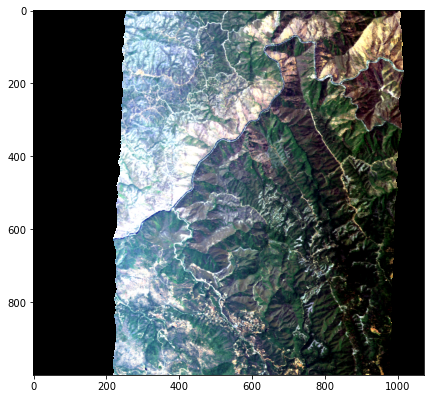

In [31]:
show_rgb(envi, correct= [])

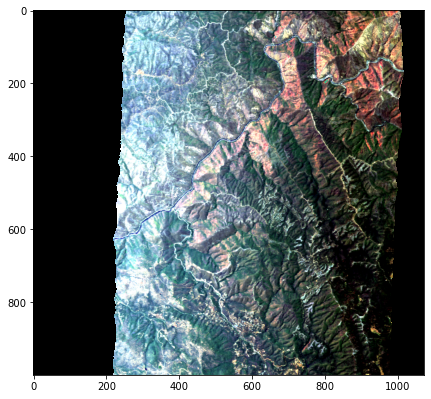

In [32]:
show_rgb(envi, correct = ['topo'])

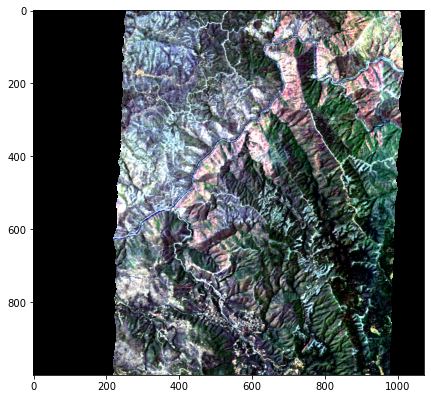

In [33]:
show_rgb(envi, correct = ['topo','brdf'])

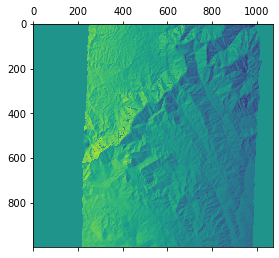

In [34]:
difference = envi.get_wave(450) - envi.get_wave(450,corrections= ['topo',
                                                                  'brdf'])
plt.matshow(difference)

## Calculate ancillary and display

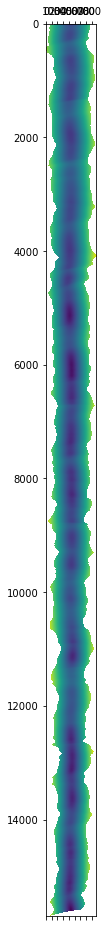

In [36]:
data = np.copy(neon.get_anc('sensor_zn', radians = False))

data[~neon.mask['no_data']] = np.nan

plt.matshow(data)

## Wavelength resampling

In [37]:
outwaves = [x for x in range(450,2500,25)]
envi.resampler = {'type': 'cubic','out_waves' :outwaves}

(0.0, 0.6)

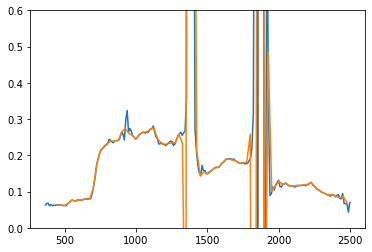

In [38]:
original = envi.get_pixels([500],[500])
resample =envi.get_pixels([500],[500], resample = True)

plt.plot(envi.wavelengths,original[0])
plt.plot(outwaves,resample[0])
plt.ylim(0,.6)